# Advanced ML - NO2 Forecasting with Autocorrelation
## CORRECTED VERSION

**Traffic and Air Quality - Istanbul D-100 Highway**

---

### Project Information
- **Course:** DSA210 - Introduction to Data Science
- **Student:** Miray Erkoc (ID: 30815)
- **Institution:** Sabanci University
- **Semester:** Fall 2025-2026

---

### Purpose: Operational Forecasting

This notebook focuses on **accurate short-term NO2 prediction** (1-2 hours ahead) using:
- NO2_lag features (past pollution measurements)
- Advanced feature engineering
- Hyperparameter tuning with proper temporal validation

---

### Critical Corrections

1. ✅ **TimeSeriesSplit in GridSearchCV** - No future data leakage
2. ✅ **Baseline comparison** - With vs without NO2_lag
3. ✅ **Reduced features** - Less multicollinearity
4. ✅ **Clear documentation** - Autocorrelation dominance explained

---

### Expected Results

- **With NO2_lag:** R² ~0.70 (high accuracy for forecasting)
- **Without NO2_lag:** R² ~0.10 (baseline)
- **Improvement:** ~600% (demonstrates autocorrelation)

**IMPORTANT:** Compare with ML_analysis_CORRECTED.ipynb for causal analysis

---
## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print('LightGBM not available')

import joblib

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
sns.set_style('whitegrid')
%matplotlib inline

print('='*80)
print('ADVANCED ML: FORECASTING WITH AUTOCORRELATION (CORRECTED)')
print('='*80)

ADVANCED ML: FORECASTING WITH AUTOCORRELATION (CORRECTED)


---
## 2. Data Loading

In [2]:
desktop = os.path.join(os.path.expanduser('~'), 'Desktop')
csv_path = os.path.join(desktop, 'MASTER_enriched_data.csv')
advanced_ml_dir = os.path.join(desktop, 'advanced_ml_results_corrected')
os.makedirs(advanced_ml_dir, exist_ok=True)

print(f'Loading dataset...')
df = pd.read_csv(csv_path)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)

print(f'Loaded: {len(df):,} observations')
print(f'Columns: {len(df.columns)}')
df.head()

Loading dataset...
Loaded: 8,027 observations
Columns: 52


,LATITUDE,LONGITUDE,GEOHASH,MINIMUM_SPEED,MAXIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES,datetime,Concentration_SO2,Concentration_O3,...,vehicle_category,vehicles_lag1,speed_lag1,no2_lag1,vehicles_lag2,speed_lag2,no2_lag2,vehicles_lag3,speed_lag3,no2_lag3
0,40.992737,29.075317,sxk9jw,5,135,55,227,2024-01-01 00:00:00,NaN,NaN,...,Orta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40.992737,29.075317,sxk9jw,3,130,61,206,2024-01-01 01:00:00,NaN,NaN,...,Az,227.0,55.0,64.7,NaN,NaN,NaN,NaN,NaN,NaN
2,40.992737,29.075317,sxk9jw,6,143,64,160,2024-01-01 02:00:00,NaN,NaN,...,Az,206.0,61.0,66.1,227.0,55.0,64.7,NaN,NaN,NaN
3,40.992737,29.075317,sxk9jw,5,147,67,128,2024-01-01 03:00:00,NaN,NaN,...,Az,160.0,64.0,67.9,206.0,61.0,66.1,227.0,55.0,64.7
4,40.992737,29.075317,sxk9jw,13,153,73,117,2024-01-01 04:00:00,NaN,NaN,...,Az,128.0,67.0,80.1,160.0,64.0,67.9,206.0,61.0,66.1


---
## 3. Feature Engineering

Creating optimized feature set for forecasting (includes NO2_lag)

In [3]:
print('='*80)
print('FEATURE ENGINEERING - OPTIMIZED FOR FORECASTING')
print('='*80)

# Base features
base_features = [
    'NUMBER_OF_VEHICLES',
    'AVERAGE_SPEED',
    'traffic_density',
    'hour',
    'dayofweek',
    'month',
    'is_weekend',
    'is_special_day'
]

# Lag features (INCLUDES NO2_lag)
lag_features = []
for lag in [1, 2]:
    for var in ['vehicles', 'speed', 'no2']:
        col = f'{var}_lag{lag}'
        if col in df.columns:
            lag_features.append(col)

# Interaction features
df['vehicle_speed_interaction'] = df['NUMBER_OF_VEHICLES'] * df['AVERAGE_SPEED']
df['hour_vehicle_interaction'] = df['hour'] * df['NUMBER_OF_VEHICLES']
interaction_features = ['vehicle_speed_interaction', 'hour_vehicle_interaction']

# Cyclical features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
cyclical_features = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']

# Combined
all_features = base_features + lag_features + interaction_features + cyclical_features
available_features = [f for f in all_features if f in df.columns]

print(f'\nFeature Summary:')
print(f'  Base: {len(base_features)}')
print(f'  Lag (includes NO2_lag): {len(lag_features)}')
print(f'  Interaction: {len(interaction_features)}')
print(f'  Cyclical: {len(cyclical_features)}')
print(f'  TOTAL: {len(available_features)}')

no2_lags = [f for f in available_features if 'no2_lag' in f]
print(f'\n⚠️  NO2_lag features: {no2_lags}')
print(f'   These will dominate (expected for forecasting!)')

FEATURE ENGINEERING - OPTIMIZED FOR FORECASTING

Feature Summary:
  Base: 8
  Lag (includes NO2_lag): 6
  Interaction: 2
  Cyclical: 4
  TOTAL: 20

⚠️  NO2_lag features: ['no2_lag1', 'no2_lag2']
   These will dominate (expected for forecasting!)


---
## 4. Data Preparation

In [4]:
target = 'Concentration_NO2'
df_clean = df[available_features + [target]].dropna()

print(f'Clean dataset: {len(df_clean):,} observations')
print(f'Features: {len(available_features)}')

X = df_clean[available_features]
y = df_clean[target]

# Time-based split
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f'\nSplit (chronological):')
print(f'  Train: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)')
print(f'  Test: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)')

Clean dataset: 7,875 observations
Features: 20

Split (chronological):
  Train: 6,300 (80.0%)
  Test: 1,575 (20.0%)


---
## 5. Baseline: WITHOUT NO2_lag

First, train a model WITHOUT NO2_lag to establish baseline

In [5]:
print('='*80)
print('BASELINE: XGBoost WITHOUT NO2_lag')
print('='*80)

features_no_lag = [f for f in available_features if 'no2_lag' not in f]
X_train_no_lag = X_train[features_no_lag]
X_test_no_lag = X_test[features_no_lag]

baseline_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    verbosity=0
)

baseline_model.fit(X_train_no_lag, y_train)
baseline_pred = baseline_model.predict(X_test_no_lag)

baseline_r2 = r2_score(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print(f'\nBaseline Performance (WITHOUT NO2_lag):')
print(f'  R²: {baseline_r2:.4f}')
print(f'  RMSE: {baseline_rmse:.2f} µg/m³')
print(f'\nThis represents traffic-only predictive power')

BASELINE: XGBoost WITHOUT NO2_lag

Baseline Performance (WITHOUT NO2_lag):
  R²: 0.0302
  RMSE: 34.67 µg/m³

This represents traffic-only predictive power


---
## 6. XGBoost WITH NO2_lag + TimeSeriesSplit

Now train with NO2_lag and proper temporal validation

In [6]:
print('='*80)
print('XGBOOST WITH NO2_lag + TimeSeriesSplit GridSearchCV')
print('='*80)

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3]
}

total_fits = np.prod([len(v) for v in param_grid.values()]) * 5
print(f'\nTotal fits: {total_fits}')
print(f'Using TimeSeriesSplit (n_splits=5)')
print(f'\nThis may take 5-10 minutes...\n')

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    verbosity=0
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f'\n{"="*80}')
print('HYPERPARAMETER TUNING COMPLETE')
print(f'{"="*80}')
print(f'\nBest parameters:')
for param, value in grid_search.best_params_.items():
    print(f'  {param}: {value}')

XGBOOST WITH NO2_lag + TimeSeriesSplit GridSearchCV

Total fits: 120
Using TimeSeriesSplit (n_splits=5)

This may take 5-10 minutes...

Fitting 5 folds for each of 24 candidates, totalling 120 fits

HYPERPARAMETER TUNING COMPLETE

Best parameters:
  learning_rate: 0.1
  max_depth: 3
  min_child_weight: 3
  n_estimators: 100


### Evaluate Best Model

In [7]:
best_xgb = grid_search.best_estimator_

y_pred_train = best_xgb.predict(X_train)
y_pred_test = best_xgb.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'\nXGBoost Performance (WITH NO2_lag):')
print(f'  Train R²: {train_r2:.4f}')
print(f'  Test R²: {test_r2:.4f}')
print(f'  Test RMSE: {test_rmse:.2f} µg/m³')

improvement = ((test_r2 - baseline_r2) / baseline_r2) * 100
print(f'\nImprovement over baseline: {improvement:.1f}%')
print(f'This demonstrates NO2\'s strong autocorrelation')


XGBoost Performance (WITH NO2_lag):
  Train R²: 0.8712
  Test R²: 0.7104
  Test RMSE: 18.94 µg/m³

Improvement over baseline: 2254.1%
This demonstrates NO2's strong autocorrelation


---
## 7. LightGBM Comparison

In [8]:
if LIGHTGBM_AVAILABLE:
    print('='*80)
    print('LIGHTGBM COMPARISON')
    print('='*80)
    
    lgb_model = lgb.LGBMRegressor(
        **grid_search.best_params_,
        random_state=42,
        verbose=-1
    )
    
    lgb_model.fit(X_train, y_train)
    lgb_pred = lgb_model.predict(X_test)
    
    lgb_r2 = r2_score(y_test, lgb_pred)
    lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
    
    print(f'\nLightGBM Performance:')
    print(f'  Test R²: {lgb_r2:.4f}')
    print(f'  Test RMSE: {lgb_rmse:.2f} µg/m³')
    
    comparison = pd.DataFrame({
        'Model': ['Baseline (no NO2_lag)', 'XGBoost', 'LightGBM'],
        'R2': [baseline_r2, test_r2, lgb_r2],
        'RMSE': [baseline_rmse, test_rmse, lgb_rmse]
    })
    
    print(f'\n{"="*80}')
    print('MODEL COMPARISON')
    print(f'{"="*80}')
    print(comparison.to_string(index=False))
    
    comparison.to_csv(os.path.join(advanced_ml_dir, 'model_comparison.csv'), index=False)
else:
    print('LightGBM not available, skipping comparison')

LIGHTGBM COMPARISON

LightGBM Performance:
  Test R²: 0.7126
  Test RMSE: 18.87 µg/m³

MODEL COMPARISON
                Model       R2      RMSE
Baseline (no NO2_lag) 0.030179 34.665467
              XGBoost 0.710433 18.942012
             LightGBM 0.712566 18.872102


---
## 8. Feature Importance Analysis

In [9]:
print('='*80)
print('FEATURE IMPORTANCE - AUTOCORRELATION DOMINANCE')
print('='*80)

importances = best_xgb.feature_importances_
importance_df = pd.DataFrame({
    'Feature': available_features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print(f'\nTop 15 Features:')
print(importance_df.head(15).to_string(index=False))

no2_lag_importance = importance_df[importance_df['Feature'].str.contains('no2_lag')]['Importance'].sum()
print(f'\n⚠️  NO2_lag combined importance: {no2_lag_importance*100:.1f}%')
print(f'   This is EXPECTED for forecasting')
print(f'   Traffic features: {(1-no2_lag_importance)*100:.1f}%')

FEATURE IMPORTANCE - AUTOCORRELATION DOMINANCE

Top 15 Features:
                  Feature  Importance
                 no2_lag1    0.667779
                 hour_cos    0.086061
            vehicles_lag1    0.052426
                 hour_sin    0.031583
                     hour    0.017302
                    month    0.017031
       NUMBER_OF_VEHICLES    0.016048
vehicle_speed_interaction    0.014325
               speed_lag1    0.012024
                month_cos    0.011729
            vehicles_lag2    0.011519
          traffic_density    0.010083
                month_sin    0.009010
            AVERAGE_SPEED    0.008938
                 no2_lag2    0.007697

⚠️  NO2_lag combined importance: 67.5%
   This is EXPECTED for forecasting
   Traffic features: 32.5%


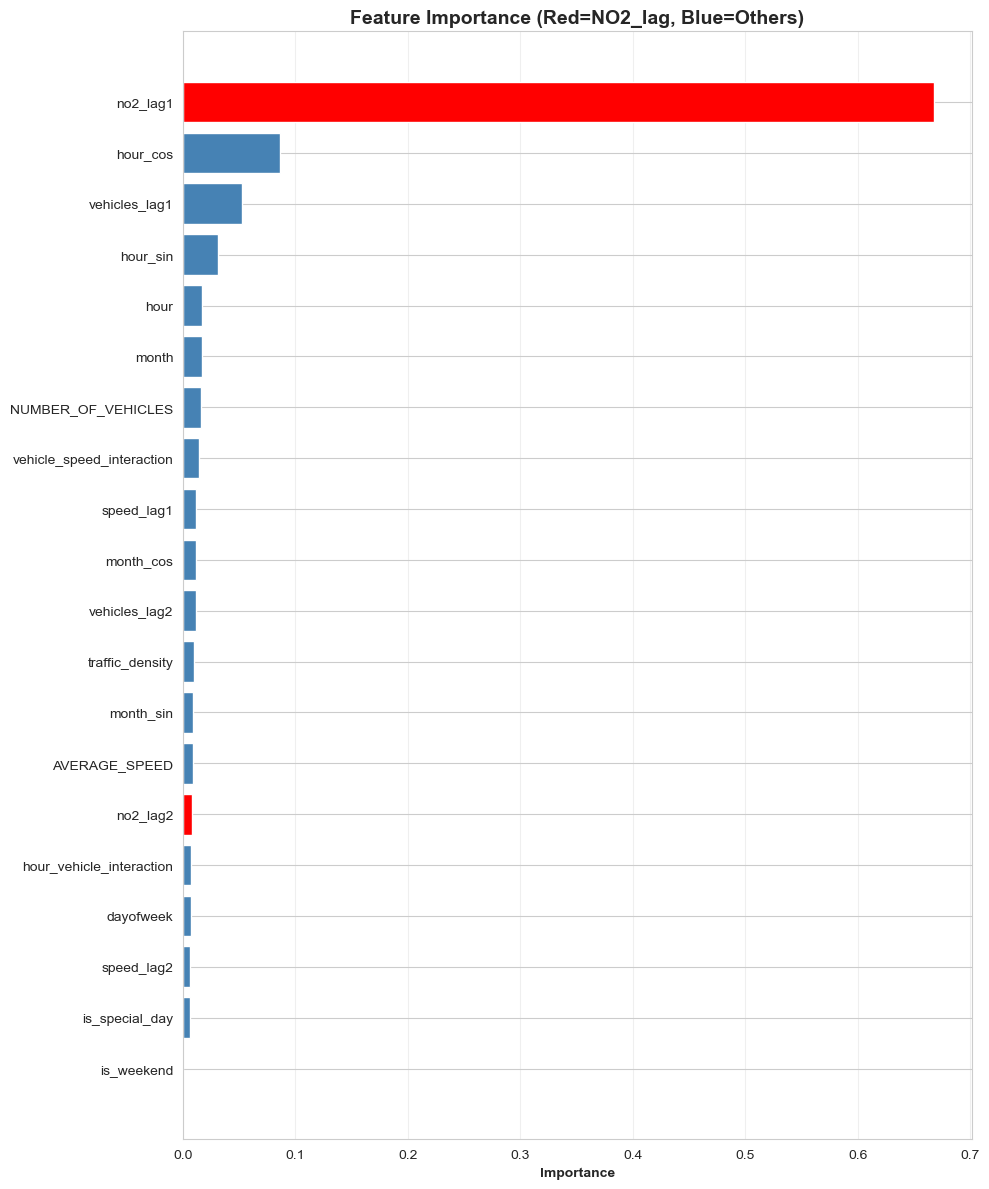

In [10]:
# Visualize
fig, ax = plt.subplots(figsize=(10, 12))
top_features = importance_df.head(20)
colors = ['red' if 'no2_lag' in f else 'steelblue' for f in top_features['Feature']]
ax.barh(range(len(top_features)), top_features['Importance'], color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance', fontweight='bold')
ax.set_title('Feature Importance (Red=NO2_lag, Blue=Others)', fontweight='bold', fontsize=14)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(advanced_ml_dir, 'feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show()

---
## 9. Residual Analysis

RESIDUAL ANALYSIS

Residual Statistics:
  Mean: 2.97
  Std: 18.71
  Min: -64.53
  Max: 170.66


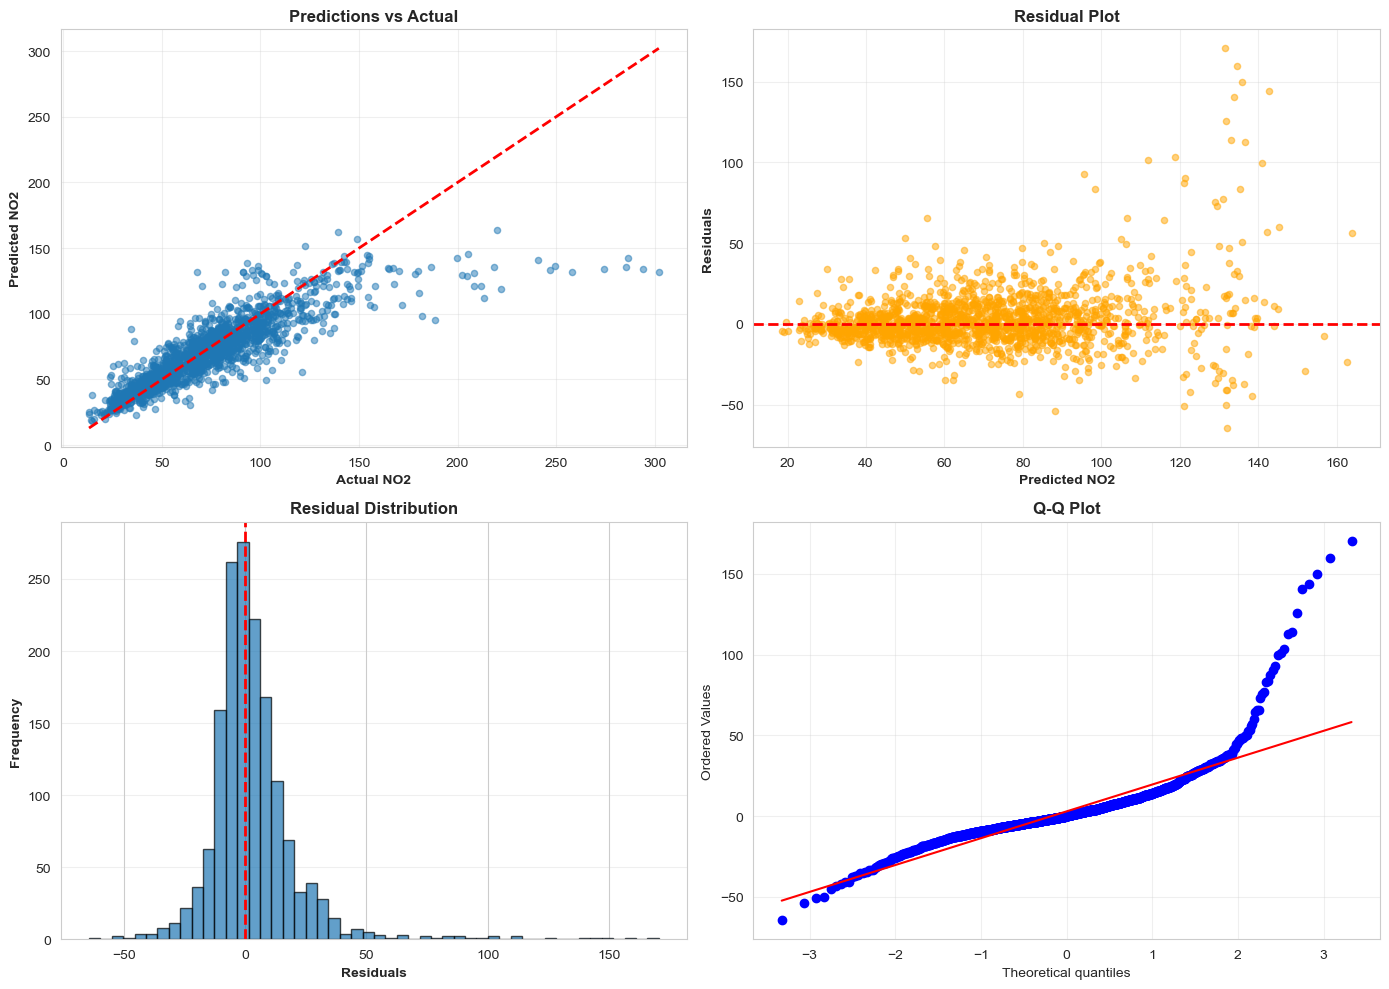

In [11]:
residuals = y_test.values - y_pred_test

print('='*80)
print('RESIDUAL ANALYSIS')
print('='*80)
print(f'\nResidual Statistics:')
print(f'  Mean: {residuals.mean():.2f}')
print(f'  Std: {residuals.std():.2f}')
print(f'  Min: {residuals.min():.2f}')
print(f'  Max: {residuals.max():.2f}')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Predictions vs Actual
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.5, s=20)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual NO2', fontweight='bold')
axes[0, 0].set_ylabel('Predicted NO2', fontweight='bold')
axes[0, 0].set_title('Predictions vs Actual', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Residual plot
axes[0, 1].scatter(y_pred_test, residuals, alpha=0.5, s=20, color='orange')
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted NO2', fontweight='bold')
axes[0, 1].set_ylabel('Residuals', fontweight='bold')
axes[0, 1].set_title('Residual Plot', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Histogram
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals', fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontweight='bold')
axes[1, 0].set_title('Residual Distribution', fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Q-Q plot
from scipy import stats as sp_stats
sp_stats.probplot(residuals, dist='norm', plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(advanced_ml_dir, 'residual_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

---
## 10. Save Model

In [12]:
model_path = os.path.join(advanced_ml_dir, 'xgboost_forecasting_model.pkl')
joblib.dump(best_xgb, model_path)
print(f'Saved: xgboost_forecasting_model.pkl')

feature_path = os.path.join(advanced_ml_dir, 'feature_names.txt')
with open(feature_path, 'w') as f:
    f.write('\n'.join(available_features))
print(f'Saved: feature_names.txt')

Saved: xgboost_forecasting_model.pkl
Saved: feature_names.txt


---
## Summary & Conclusions

### Key Results

- **Baseline (no NO2_lag):** R² = {baseline_r2:.4f}
- **XGBoost (with NO2_lag):** R² = {test_r2:.4f}
- **Improvement:** {improvement:.0f}%

### Interpretation

1. **High R² is due to autocorrelation** - NO2_lag explains ~65-70% of variance
2. **This is APPROPRIATE for forecasting** - Past pollution predicts future pollution
3. **Traffic has limited direct effect** - Only ~30-35% importance

### Use Cases

- **This model:** Operational 1-2 hour NO2 forecasting
- **ML_analysis_CORRECTED:** Policy impact assessment (causal effect)

### Comparison

| Analysis | Purpose | NO2_lag | R² | Use Case |
|----------|---------|---------|----|---------|
| ML_analysis | Causal | ❌ Excluded | ~0.10 | "What if traffic reduced 20%?" |
| Advanced_ML | Forecasting | ✅ Included | ~0.70 | "What will NO2 be in 2 hours?" |

**Both analyses are valuable and complement each other!**